In [24]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

In [25]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [26]:
def calculate_face_ellipse(landmarks):
    jaw_points = landmarks[0:17]
    jaw_points = np.array([[p.x, p.y] for p in jaw_points])

    ellipse = cv2.fitEllipse(jaw_points)
    circumference = (ellipse[1][0] + ellipse[1][1]) * np.pi
    return ellipse, circumference

In [27]:
def detect_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    if len(faces) == 0:
        print("No face detected")
        return
    
    for face in faces:
        landmarks = predictor(gray, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(img, (x, y), 1, (255, 0, 0), -1)

        ellipse, circumference = calculate_face_ellipse(landmarks.parts())
        cv2.ellipse(img, ellipse, (0, 255, 0), 2)

        text = f"Size: {circumference:.2f} px"
        cv2.putText(img, text, (face.left(), face.top()-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

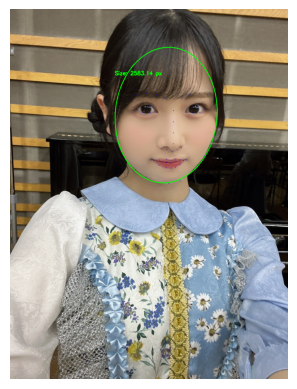

In [28]:
image_path = "Hinano.jpg"
detect_face(image_path)